## Import libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint

from keras.utils.vis_utils import plot_model

from tensorflow.keras.models import load_model

import pickle
import numpy as np
import os

## Load txt file

In [ ]:
from google.colab import files
file = files.upload()

Saving pg2641.txt to pg2641.txt


## The txt file is collected from https://www.gutenberg.org/ebooks/2641

## Open and pre-process the data

In [ ]:
file = open('pg2641.txt', 'r')

#Store data of the txt file in a list
doc = []
for i in file:
  doc.append(i)

# Convert list to string
data = ""
for i in doc:
  data = ' '. join(doc) 

#replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')\
            .replace('“','').replace('”','')  #new line, carriage return, unicode character --> replace by space


In [ ]:
#remove unnecessary spaces 
data = data.split()
data = ' '.join(data)
print(data[:100])
print(f"Total number of words is {len(data)}")

The Project Gutenberg eBook of A Room With A View, by E. M. Forster This eBook is for the use of any
Total number of words is 387734


## Apply tokenization and some other changes

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))
data_sequence = tokenizer.texts_to_sequences([data])[0]
print(data_sequence[:15])

[1, 114, 105, 573, 4, 5, 115, 19, 5, 195, 46, 310, 1223, 1839, 33]


In [ ]:
print(f"length of data_sequence is {len(data_sequence)}")

length of data_sequence is 70167


In [ ]:
X,y  = [], []
k = 3
for i in range(k, len(data_sequence)):
    words = data_sequence[i-k:i+1]
    X.append(words[: k])
    y.append(words[k])
    
print("The Length of sequences are: ", len(X))
X = np.array(X)
y = np.array(y)
print(f"Data : \n{X[:10]}")
print(f"Response : \n{y[:10]}")

The Length of sequences are:  70164
Data : 
[[  1 114 105]
 [114 105 573]
 [105 573   4]
 [573   4   5]
 [  4   5 115]
 [  5 115  19]
 [115  19   5]
 [ 19   5 195]
 [  5 195  46]
 [195  46 310]]
Response : 
[ 573    4    5  115   19    5  195   46  310 1223]


In [ ]:
vocab_size = len(tokenizer.word_index) + 1 # 0 is reserved for padding and that's why we add 1
print(f"No of different words is {vocab_size}")

No of different words is 7866


In [ ]:
y = to_categorical(y, num_classes = vocab_size)
print(y[:10])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Model

In [ ]:
model = Sequential(name='LSTM')
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [ ]:
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             78660     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 7866)              7873866   
                                                                 
Total params: 21,001,526
Trainable params: 21,001,526
Non-trainable params: 0
_________________________________________________________________


## Plot the model

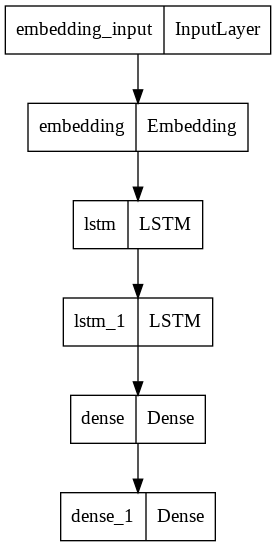

In [ ]:
keras.utils.plot_model(model, to_file='plot.png', show_layer_names=True)

## Train the model

In [ ]:
checkpoint = ModelCheckpoint('next_words.h5', monitor = 'loss', verbose = 1, save_best_only = True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X, y, epochs = 70, batch_size = 64, callbacks=[checkpoint])

Epoch 1/70
1094/1097 [============================>.] - ETA: 0s - loss: 6.7001 - accuracy: 0.0482
Epoch 1: loss improved from inf to 6.69918, saving model to next_words.h5
1097/1097 [==============================] - 27s 17ms/step - loss: 6.6992 - accuracy: 0.0483
Epoch 2/70
1097/1097 [==============================] - ETA: 0s - loss: 6.1879 - accuracy: 0.0699
Epoch 2: loss improved from 6.69918 to 6.18786, saving model to next_words.h5
1097/1097 [==============================] - 19s 18ms/step - loss: 6.1879 - accuracy: 0.0699
Epoch 3/70
1096/1097 [============================>.] - ETA: 0s - loss: 5.8179 - accuracy: 0.0938
Epoch 3: loss improved from 6.18786 to 5.81792, saving model to next_words.h5
1097/1097 [==============================] - 20s 18ms/step - loss: 5.8179 - accuracy: 0.0938
Epoch 4/70
1096/1097 [============================>.] - ETA: 0s - loss: 5.5033 - accuracy: 0.1092
Epoch 4: loss improved from 5.81792 to 5.50317, saving model to next_words.h5
1097/1097 [==========

## predict

In [ ]:
model = load_model('next_words.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

In [33]:
while True:
  text = input('Please enter sentence(Please write more than 2 words), 0 to exit: ')
  if text != '0':
    try:
      text = text.split(' ')
      text = text[-3: ]
      sequence = np.array(tokenizer.texts_to_sequences([text]))

      output = np.argpartition(model.predict(sequence)[0], -5)[-5:]
      preds = np.argmax(model.predict(sequence))
      predicted_word = ""    

      next_words = []
      for key, value in tokenizer.word_index.items():
        if value in output:
          next_words.append(key)

        if value == preds:
          predicted_word = key

        if len(next_words) == 5:
          break
      print(f"Possible predicted words:\n{next_words}")
      print(f"Most predicted word: {predicted_word}")
    except Exception as e:
      print(e)
  else:
    break

Please enter sentence(Please write more than 2 words), 0 to exit: who hurried forward
1/1 [==============================] - 0s 14ms/step
Possible predicted words:
['the', 'to', 'i', 'is', 'with']
Most predicted word: to
Please enter sentence(Please write more than 2 words), 0 to exit: 0


In [35]:
while True:
  text = input('Please enter sentence(Please write more than 2 words), 0 to exit: ')
  list = []
  if text != '0':
    n = int(input("No of word want to predict:"))
    text = text.split(' ')
    for _ in range(n):
        try:          
          print(text)
          text = text[-3: ]
          sequence = np.array(tokenizer.texts_to_sequences([text]))

          # output = np.argpartition(model.predict(sequence)[0], -5)[-5:]
          preds = np.argmax(model.predict(sequence))
          predicted_word = ""    

          next_words = []
          for key, value in tokenizer.word_index.items():
            if value == preds:
              predicted_word = key

          # print(next_words)
          list.append(predicted_word)
          text.append(predicted_word)
        except Exception as e:
          print(e)
    print(f"Next {n} predicted word is {list}")
  else:
    break

Please enter sentence(Please write more than 2 words), 0 to exit: who hurried forward
No of word want to predict:3
['who', 'hurried', 'forward']
1/1 [==============================] - 0s 21ms/step
['who', 'hurried', 'forward', 'to']
1/1 [==============================] - 0s 17ms/step
['hurried', 'forward', 'to', 'take']
1/1 [==============================] - 0s 16ms/step
Next 3 predicted word is ['to', 'take', 'his']
Please enter sentence(Please write more than 2 words), 0 to exit: 0
